In [314]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score

 # 1.Read csv data files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = [train,test]
#train.head()

In [315]:
 # 2.Data Cleaning
 # Age: replace the NA in Age column with the median of the train set
for dataset in full_data:
    dataset['Age'] = dataset['Age'].fillna(train['Age'].median())
 # Convert non-numeric column to numeric:
 # Sex: male=0,female=1
#print(train['Sex'].unique())
    dataset.loc[dataset['Sex'] == 'male','Sex'] = 0
    dataset.loc[dataset['Sex'] == 'female','Sex'] = 1
 # Fare: replace the NA in Fare with the median of the train set
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
 # Embark: fill the NA with S, which is the most common embark port
 # Let S=0, C=1, Q=2
#print(train["Embarked"].unique())
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset.loc[dataset['Embarked']=='S','Embarked']=0
    dataset.loc[dataset['Embarked']=='C','Embarked']=1
    dataset.loc[dataset['Embarked']=='Q','Embarked']=2

In [316]:
 # 3.Feature Engineering
 # Check each feature in the given data
 # Pclass
print('Survived Rate based on Pclass')
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
 # Sex
print('Survived Rate based on Sex')
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
 # Age
print('Survived Rate based on Age')
train['Age'] = train['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())
 # Fare
print('Survived Rate based on Fare')
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())
 # Embarked
print('Survived Rate based on Embarked')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
 # Create new features to improve model
 # SibSp & Parch
 # Use SibSp:Siblings&Spouse and Parch:Parents&Children to create new feature: FamSize

for dataset in full_data:
    dataset['FamSize'] = dataset['SibSp'] + dataset['Parch'] + 1
#print (train[['FamSize', 'Survived']].groupby(['FamSize'], as_index=False).mean())
 # Based on the result we further categorize the FamSize into Alone or Not Alone
for dataset in full_data:
    dataset['Alone'] = 0
    dataset.loc[dataset['FamSize'] == 1, 'Alone'] = 1
print('Survived Rate based on Family Size')
print (train[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean())
 # Names
 # First we can generate the length of name, which may indicate a person's social status
for dataset in full_data:
    dataset["NameLen"] = dataset["Name"].apply(lambda x: len(x))
    dataset['CategoricalNameLen'] = pd.cut(dataset['NameLen'], 7)
print('Survived Rate based on Name Length')
print (train[['CategoricalNameLen', 'Survived']].groupby(['CategoricalNameLen'], as_index=False).mean())
 # Use Names to extract titles

 # Write a function to extract the title from a name: *Ref to dataquest
def get_title(name):
    # Represent title with a regular expression: consist of letters,lowercase or capital, and end with a period
    find_title = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it
    if find_title:
        return find_title.group(1)
    return ""
 # Get all the titles, and print the count of each one
titles = train["Name"].apply(get_title)
 # Map each title to an integer 
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, 
                 "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, 
                 "Capt": 7, "Ms": 2}
 # Compressed rare titles into the same codes as other titles
for k,v in title_mapping.items():
    titles[titles == k] = v
for dataset in full_data:
    dataset['Title'] = titles
print('Survived Rate based on titles')
print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

Survived Rate based on Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
Survived Rate based on Sex
   Sex  Survived
0    0  0.188908
1    1  0.742038
Survived Rate based on Age
  CategoricalAge  Survived
0  (-0.08, 16.0]  0.550000
1   (16.0, 32.0]  0.344762
2   (32.0, 48.0]  0.403226
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909
Survived Rate based on Fare
   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081
Survived Rate based on Embarked
   Embarked  Survived
0         0  0.339009
1         1  0.553571
2         2  0.389610
Survived Rate based on Family Size
   Alone  Survived
0      0  0.505650
1      1  0.303538
Survived Rate based on Name Length
  CategoricalNameLen  Survived
0      (11.93, 22.0]  0.252336
1       (22.0, 32.0]  0.366584
2       (32.0, 42.0]  0.554348
3       (42.0, 52.0]  0.841270
4       (52.0, 62.0]  0.636364
5       (62.0, 72

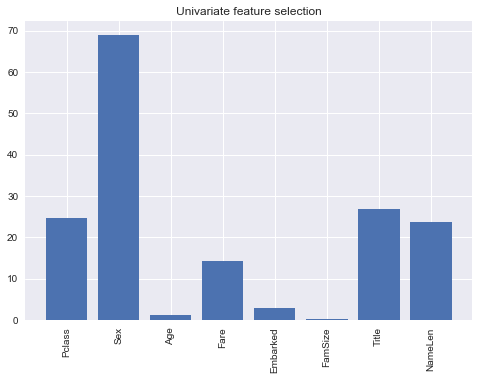

In [317]:
 # 3. Feature Engineering Continued
 # Identify the best classifiers with univariate feature selection
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamSize", "Title", "NameLen"]
 # Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(train[predictors], train["Survived"])

# Get the raw p-values for each feature, and transform them from p-values into scores
scores = -np.log10(selector.pvalues_)
# Plot the scores  
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.title('Univariate feature selection')
plt.show()

In [318]:
# 4.Ensembling Models
# Ensemble different classifiers to improve the prediction accuracy

# Ignore the 2 lowest effective features: Age, FamSize
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title", "NameLen"]
# The algorithms we want to ensemble: Logistic Regression and Gradient boosting classifier 
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), 
     predictors],
    [LogisticRegression(random_state=1), predictors]]
# Initialize the cross-validation folds
kf = KFold(train.shape[0], n_folds=3, random_state=1)

# Make predictions for each algorithm on each fold
predictions = []
auc_score = []
for traindata, testdata in kf:
    train_target = train["Survived"].iloc[traindata]
    full_test_predictions = []
    for alg, predictor in algorithms:
        # Fit the algorithm on the training data
        alg.fit(train[predictor].iloc[traindata,:], train_target)
        # Select and predict on the test fold 
        test_predictions = alg.predict_proba(train[predictor].iloc[testdata,:].astype(float))[:,1]
        auc = roc_auc_score(train['Survived'].iloc[testdata],test_predictions)
        auc_score.append(auc)
        full_test_predictions.append(test_predictions)
    # First we average the predictions to get the final classification
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)
# Put all the predictions together into one array
predictions = np.concatenate(predictions, axis=0)
auc_score_mean = sum(auc_score)/len(auc_score)
print('AUC score:')
print(auc_score_mean)

AUC score:
0.849413672946


In [319]:
# 4.Ensembling Models Continued: Classifier Comparison
# Logistic Regression & Gradient Boosting Classifier KFold cross validation score

alg_lr = LogisticRegression(random_state=1)
alg_gb = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
scores_lr = cross_validation.cross_val_score(alg_lr, train[predictors], train["Survived"], cv=3)
scores_gb = cross_validation.cross_val_score(alg_gb, train[predictors], train["Survived"], cv=3)
print('Linear Regression cross validation score:')
print(scores_lr.mean())
print('Gradient Boosting cross validation score:')
print(scores_gb.mean())

Linear Regression cross validation score:
0.7822671156
Gradient Boosting cross validation score:
0.809203142536


In [320]:
# 4.Ensembling Models Continued
# Predict on the test dataset
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1),predictors]]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the training data
    alg.fit(train[predictors], train["Survived"])
    # Predict using the test dataset
    predictions = alg.predict_proba(test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# According to the score above,the gradient boosting classifier generates better predictions, so we weight it higher
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1

predictions = predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,0
4,896,0
